In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
data = pd.read_csv('/content/drive/MyDrive/TSA_BDA_2024/Lab9/monthly_in_situ_co2_mlo.csv', skiprows=61)

In [4]:
data

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally,Sta
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled,NaN
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm],NaN
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
4,1958,03,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44,MLO
...,...,...,...,...,...,...,...,...,...,...,...
801,2024,08,45519,2024.6230,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
802,2024,09,45550,2024.7077,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
803,2024,10,45580,2024.7896,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO
804,2024,11,45611,2024.8743,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,MLO


Preparing the data

In [5]:
data.columns = data.columns.str.strip()
data.columns
data['Yr'] = data['Yr'].str.strip()
data['Mn'] = data['Mn'].str.strip()

In [6]:
data.dropna(inplace=True)
data.drop(data.head(4).index, inplace=True)
data.drop(data.tail(9).index, inplace=True)
co2_data = data.loc[:,['Yr', 'Mn', 'CO2']]
co2_data['DateCons'] = co2_data['Yr'].astype(str) + '-' + co2_data['Mn'].astype(str) + '-01'

In [7]:
co2_data['DatePart'] = pd.to_datetime(co2_data['DateCons'], format='%Y-%m-%d', errors='coerce')
co2_data.rename(columns = {"DatePart" : "Date"}, inplace=True)
co2_data.set_index("Date", inplace=True)
co2_data.drop(columns=["DateCons"], inplace=True)

In [8]:
co2_data = co2_data.iloc[:, [3]]
co2_data ['CO2'] = co2_data ['CO2'].astype(float)

<ipython-input-8-74b60c3e6da4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2_data ['CO2'] = co2_data ['CO2'].astype(float)


CO2 Emissions  Time series

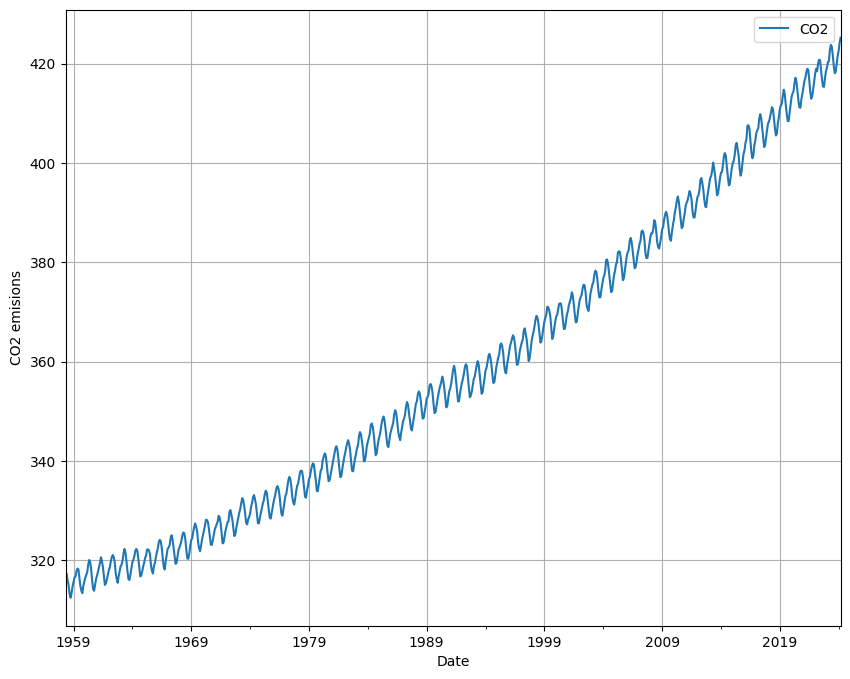

In [9]:
co2_data.plot(figsize=(10,8), grid=True)
plt.ylabel("CO2 emisions")
plt.show()

In [10]:
co2_data.sort_index(inplace=True)

In [11]:
co2_data.index.freq='MS'

In [12]:
df = co2_data.copy()

In [13]:
df['CO2'].shift(0)

Date
1958-05-01    317.51
1958-06-01    317.27
1958-07-01    315.87
1958-08-01    314.93
1958-09-01    313.21
               ...  
2023-11-01    420.12
2023-12-01    421.65
2024-01-01    422.62
2024-02-01    424.35
2024-03-01    425.22
Freq: MS, Name: CO2, Length: 791, dtype: float64

In [14]:
for i in range(12,0,-1):
    print(i)
    df['t= ' + str(i)] =df['CO2'].shift(i)

12
11
10
9
8
7
6
5
4
3
2
1


Preparing time series for prediction

In [15]:
df

,CO2,t= 12,t= 11,t= 10,t= 9,t= 8,t= 7,t= 6,t= 5,t= 4,t= 3,t= 2,t= 1
Date,,,,,,,,,,,,,
1958-05-01,317.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-06-01,317.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.51
1958-07-01,315.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.51,317.27
1958-08-01,314.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.51,317.27,315.87
1958-09-01,313.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317.51,317.27,315.87,314.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,420.12,417.03,418.48,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40
2023-12-01,421.65,418.48,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40,420.12
2024-01-01,422.62,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40,420.12,421.65


In [16]:
df.dropna(inplace=True)

prepared time series for prediction

In [17]:
df

,CO2,t= 12,t= 11,t= 10,t= 9,t= 8,t= 7,t= 6,t= 5,t= 4,t= 3,t= 2,t= 1
Date,,,,,,,,,,,,,
1959-05-01,318.29,317.51,317.27,315.87,314.93,313.21,312.42,313.33,314.67,315.58,316.49,316.65,317.72
1959-06-01,318.15,317.27,315.87,314.93,313.21,312.42,313.33,314.67,315.58,316.49,316.65,317.72,318.29
1959-07-01,316.54,315.87,314.93,313.21,312.42,313.33,314.67,315.58,316.49,316.65,317.72,318.29,318.15
1959-08-01,314.80,314.93,313.21,312.42,313.33,314.67,315.58,316.49,316.65,317.72,318.29,318.15,316.54
1959-09-01,313.84,313.21,312.42,313.33,314.67,315.58,316.49,316.65,317.72,318.29,318.15,316.54,314.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,420.12,417.03,418.48,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40
2023-12-01,421.65,418.48,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40,420.12
2024-01-01,422.62,419.23,420.33,420.51,422.73,423.78,423.39,421.62,419.56,418.06,418.40,420.12,421.65


In [18]:
X = df.iloc[:,1:].values

In [19]:
y = df.iloc[:, 0].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

GRID Search for best params of Random Forest Regressor

In [ ]:
parameters = {
     'max_features': [3,4,5],
     'n_estimators': [100, 200, 500]

}
clf_gbm = GridSearchCV(RandomForestRegressor(), parameters, cv=8)
clf_gbm.fit(X_train, y_train)
print("Best parameters:", clf_gbm.best_params_)
print("Best score:", clf_gbm.best_score_)

Best parameters: {'max_features': 5, 'n_estimators': 500}
Best score: 0.9995718760856878


Regression with Random Forest

In [21]:
rfr =RandomForestRegressor(random_state=42,n_estimators=500,max_features=5)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_features=5, n_estimators=500, random_state=42)

In [22]:
train_prediction = rfr.predict(X_train)
test_prediction = rfr.predict(X_test)

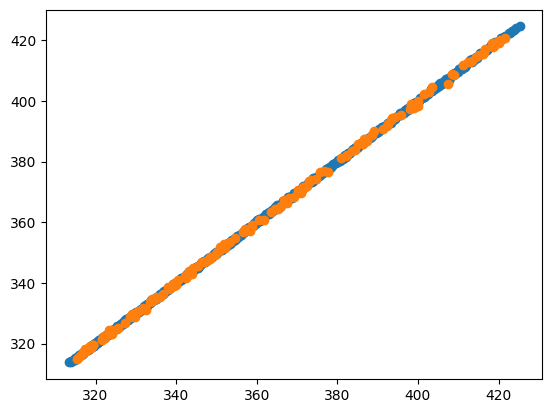

In [23]:
plt.scatter(y_train,train_prediction)
plt.scatter(y_test,test_prediction)

In [24]:
mean_absolute_percentage_error(y_train, train_prediction)*100

0.04918088070645875

In [25]:
mean_absolute_percentage_error(y_test, test_prediction)*100

0.12741933601819283

In [26]:
def get_first_eval_batch(data, n):
    return data[-n:].reshape(-1,n)

In [27]:
train = co2_data[:-12]
test = co2_data[-12:]

In [28]:
n_lag = 12
test_prediction_rfr = []
current_batch = get_first_eval_batch(train['CO2'].values, n_lag)
for i in range(len(test)):
    current_pred = rfr.predict(current_batch)[0]
    test_prediction_rfr.append(current_pred)
    current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, n_lag)

In [29]:
test_prediction_rfr

[422.49870000000215,
 423.4473400000001,
 422.94332000000264,
 421.60557999999827,
 419.63795999999905,
 418.5546199999989,
 419.0403400000003,
 419.2844600000012,
 420.4948200000006,
 422.0894599999997,
 423.7748000000014,
 424.1403400000014]

Actual vs Predicted values using RandomForest Regression

<Axes: xlabel='Date'>

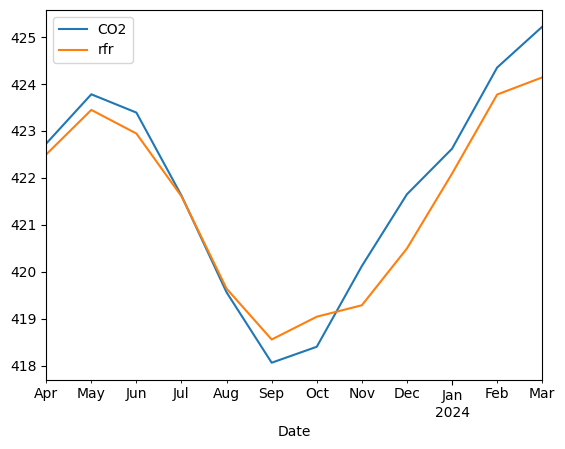

In [30]:
df_comp =test['CO2'].to_frame()
df_comp['rfr'] = test_prediction_rfr
df_comp.plot()

In [31]:
mean_absolute_percentage_error(df_comp['CO2'], df_comp['rfr'])*100

0.1266594143067228

Gradient Boost Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

Running Grid Search to look for best params

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 500],
    'max_features' : [3,4,5]

}
clf_gbm = GridSearchCV(GradientBoostingRegressor(), parameters, cv=8)
clf_gbm.fit(X_train, y_train)

print("Best parameters:", clf_gbm.best_params_)
print("Best score:", clf_gbm.best_score_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 5, 'n_estimators': 500}
Best score: 0.9995220285574494


In [ ]:
gbr = GradientBoostingRegressor(random_state=42,n_estimators=500,max_features=5, learning_rate=0.05, max_depth=5)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features=5,
                          n_estimators=500, random_state=42)

In [ ]:
train_prediction = gbr.predict(X_train)
test_prediction = gbr.predict(X_test)

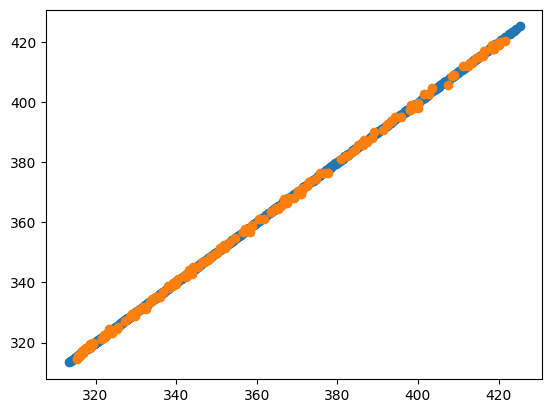

In [ ]:
plt.scatter(y_train,train_prediction)
plt.scatter(y_test,test_prediction)

In [ ]:
mean_absolute_percentage_error(y_train, train_prediction)*100

0.012278367102289058

In [ ]:
mean_absolute_percentage_error(y_test, test_prediction)*100

0.13256530777559283

In [ ]:
n_lag = 12
test_prediction_gbr = []
current_batch = get_first_eval_batch(train['CO2'].values, n_lag)
for i in range(len(test)):
    current_pred = gbr.predict(current_batch)[0]
    test_prediction_gbr.append(current_pred)
    current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, n_lag)

Actual vs Predicted values for Gradient Boost

<Axes: xlabel='Date'>

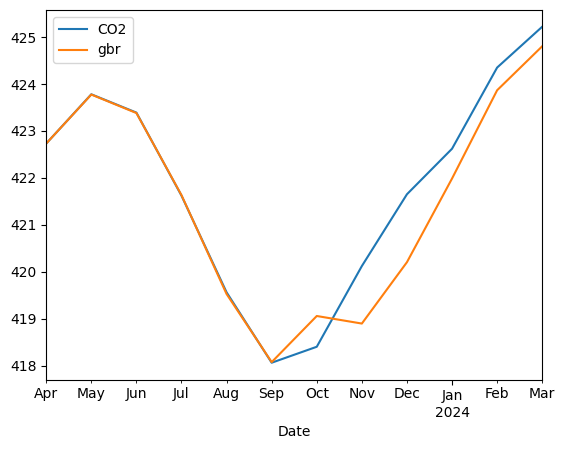

In [ ]:
df_comp =test['CO2'].to_frame()
df_comp['gbr'] = test_prediction_gbr
df_comp.plot()

In [ ]:
mean_absolute_percentage_error(df_comp['CO2'], df_comp['gbr'])*100

0.0976487544068113

Xtreme Gradient Boosting Regression

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
xgbr= xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
train_prediction = xgbr.predict(X_train)
test_prediction = xgbr.predict(X_test)

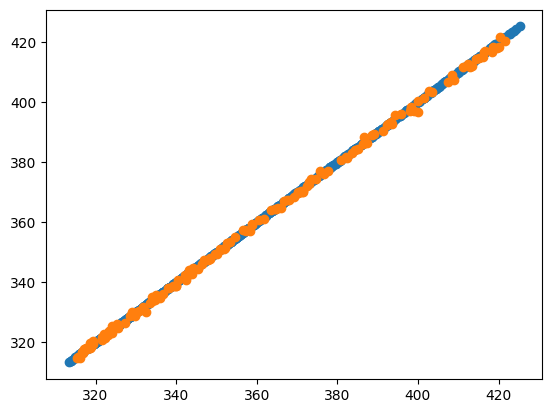

In [ ]:
plt.scatter(y_train,train_prediction)
plt.scatter(y_test,test_prediction)

In [ ]:
mean_absolute_percentage_error(y_train, train_prediction)*100

0.0014265072449335934

In [ ]:
mean_absolute_percentage_error(y_test, test_prediction)*100

0.1755306919523586

In [ ]:
n_lag = 12
test_prediction_xgbr = []
current_batch = get_first_eval_batch(train['CO2'].values, n_lag)
for i in range(len(test)):
    current_pred = xgbr.predict(current_batch)[0]
    test_prediction_xgbr.append(current_pred)
    current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, n_lag)

Actual vs Predicted Values for XGBoost Regression

<Axes: xlabel='Date'>

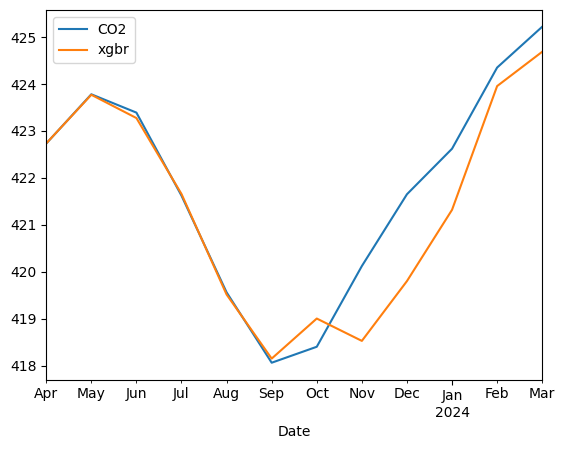

In [ ]:
df_comp =test['CO2'].to_frame()
df_comp['xgbr'] = test_prediction_gbr
df_comp.plot()

In [ ]:
mean_absolute_percentage_error(df_comp['CO2'], df_comp['xgbr'])*100

0.1299934183045117

Gradient Booster yielded the best results out of the three regressions models with mean absolute percentage error being ~ 0.09